# Introduction to Optuna + RAPIDS

Hyperparameter optimization is the task of picking values for the hyperparamters of the model to yield optimal results. This can help boost the model accuracy greatly, but can be resource-intensive and is often not widely used for practical purposes. Let's take a look at how we can use Optuna and RAPIDS to make HPO less time-consuming.


## Optuna
[Optuna](https://optuna.readthedocs.io/en/stable/) is a lightweight framework for automatic hyperparameter optimization. It provides a define-by-run API, which makes it easy to adapt to any already existing code that we have and enables high modularity and the flexibility to construct hyperparameter spaces dynamically. By simply wrapping the objective function with Optuna can help perform a parallel-distributed HPO search over a search space. As we'll see in this notebook.


## RAPIDS
RAPIDS framework provides a library suite that can execute end-to-end data science pipelines entirely on GPUs. One of the libraries in this framework is cuML, which contains various Machine Learning algorithms that take advantage of GPU to run. You can learn more about RAPIDS [here](https://rapids.ai/about.html).


In this notebook, we'll use Airlines dataset (20M rows) to predict if a flight will be delayed or not. We'll explore how to use Optuna with RAPIDS in combination with Dask to run multi-GPU HPO runs.

In [ ]:
# Run this cell to install optuna and mlflow
# !pip install optuna
# !pip install mlflow

In [2]:
import random
import time
from contextlib import contextmanager

import cudf
import cuml
import dask_cudf
import mlflow
import numpy as np
import optuna
import pandas as pd
import sklearn
import os
from cuml.dask.common import utils as dask_utils
from cuml.metrics import accuracy_score
from cuml.preprocessing.model_selection import train_test_split
from dask.distributed import Client, wait, performance_report
from joblib import parallel_backend, Parallel, delayed

from sklearn.datasets import load_iris

from dask_cuda import LocalCUDACluster

In [3]:
# Helper function for timing blocks of code.
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print("..%-24s:  %8.4f" % (name, t1 - t0))

## Set up CUDA Cluster

We start a local cluster and keep it ready for running distributed tasks with dask.

[LocalCUDACluster](https://github.com/rapidsai/dask-cuda) launches one Dask worker for each GPU in the current systems. It's developed as a part of the RAPIDS project. Learn More:
- [Setting up Dask](https://docs.dask.org/en/latest/setup.html)
- [Dask Client](https://distributed.dask.org/en/latest/client.html)

In [4]:
# This will use all GPUs on the local host by default
cluster = LocalCUDACluster(threads_per_worker=1, ip="", dashboard_address="8002")
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
n_streams = 8 # Performance optimization
c

Client Scheduler: tcp://172.17.0.4:39945 Dashboard: http://172.17.0.4:8002/status,Cluster Workers: 2 Cores: 2 Memory: 49.16 GB


## Loading the data

### Data Acquisition

We'll use the cell below to download the data. The `file_name` specifies which of the two available files - airline_small.parquet (smaller file) and airline_20000000.parquet we want to use. By default, we use the smaller file, but the benchmarks were run with the larger file. You are free to change it for experimentation.

Set the `download_data=True` and `data_dir` to a local path in your system to download the data into the path of `data_dir`

In [5]:
download_data = False

file_name = 'airline_small.parquet' # NOTE: Change to airline_20000000.parquet to use a larger dataset

data_dir = "/home/data/airline_data/" # NOTE: Change to a local path where you want to save the file
INPUT_FILE = os.path.join(data_dir, file_name)

In [6]:
if download_data:
    from urllib.request import urlretrieve

    if os.path.isfile(INPUT_FILE):
            print(f" > File already exists. Ready to load at {INPUT_FILE}")
    else:
        # Ensure folder exists
        os.makedirs(data_dir, exist_ok=True)

    url = "https://rapidsai-cloud-ml-sample-data.s3-us-west-2.amazonaws.com/" + file_name

    urlretrieve(url= url,filename=INPUT_FILE)

    print("Completed!")

Select the `N_TRIALS` for the number of runs of HPO trials. 

We will now, load the data from `INPUT_FILE`

In [7]:
N_TRIALS = 20

df = cudf.read_parquet(INPUT_FILE)
X, y = df.drop(["ArrDelayBinary"], axis=1), df["ArrDelayBinary"].astype('int32')

# Training and Evaluation

Here, we define `train_and_eval` function which simply fits a RandomForestClassifier (with`max_depth` and `n_estimators`) on the passed `X_param`, `y_param`. This function should look very similar for any ML workflow. We'll use this function within the Optuna `objective` function to show how easily we can fit an existing workflow into the Optuna work. 

In [8]:
def train_and_eval(X_param, y_param, max_depth=16, n_estimators=100):
    """
        Splits the given data into train and test split to train and evaluate the model
        for the params parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training
        max_depth, n_estimators: The values to use for max_depth and n_estimators for RFC.
                                 Defaults to 16 and 100 (the defaults for the classifiers used)
                   
        Returns
        score: Accuracy score of the fitted model
    """

    X_train, X_valid, y_train, y_valid = train_test_split(X_param, y_param, random_state=77)
    classifier = cuml.ensemble.RandomForestClassifier(max_depth=max_depth,
                     n_estimators=n_estimators)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_valid)
    score = accuracy_score(y_valid, y_pred)
    return score

For a baseline number, let's see what the default performance of RFC is. Note the defauly values for `max_depth` = 16 and `n_estimators` = 100; we pass these to the `train_and_eval` function.

In [9]:
print("Score with default parameters : ",train_and_eval(X, y, max_depth=16, n_estimators=100))

Score with default parameters :  0.8375402092933655


## Objective Function

The objective function will be the one we optimize in [Optuna Study](https://optuna.readthedocs.io/en/stable/reference/study.html). Objective funciton tries out different values for the parameters that we are tuning and saving the results in `study.trials_dataframes()`. 

Let's define the objective function for this HPO task by making use of the `train_and_eval()`. You can see that we simply choose a value for the parameters and call the `train_and_eval` method, making Optuna very easy to use in an existing workflow.

The objective remains constant over different [samplers](https://optuna.readthedocs.io/en/stable/reference/samplers.html), which are built-in options in Optuna to enable the selection of different sampling algorithms that optuna provides. Some of the available ones include - GridSampler, RandomSampler, TPESampler, etc. We'll use TPESampler for this demo, but feel free to try different samplers to notice the chnages in performance.

In [10]:
def objective(trial, X_param, y_param):
    max_depth = trial.suggest_int("max_depth", 10, 15)
    n_estimators = trial.suggest_int("n_estimators", 200, 700)
    score = train_and_eval(X_param, y_param, max_depth=max_depth,
                           n_estimators=n_estimators)
    return score

## HPO Trials and Study

Optuna uses [study](https://optuna.readthedocs.io/en/stable/reference/study.html) and [trials](https://optuna.readthedocs.io/en/stable/reference/trial.html) to keep track of the HPO experiments. Put simply, a trial is a single call of the objective function while a set of trials make up a study. We will pick the optimal performing trial from a study to get the best parameters that were used in that run.

We'll make use of a helper function `run_study` to help us run one multi-GPU study with a dask backend using [Joblib](https://joblib.readthedocs.io/en/latest/). We make use of `parallel_backend` from Joblib to allow the optuna studies to run in parallel on the GPUs as we make use of the dask backend. As you can observe, it accepts the client that we set up earlier and the data X and y are scattered across them - this reduces the time it takes for data transfer among the GPUs.

Optuna also requires the used of a storage to run distributed optimization runs. Learn more about what storages can be used [here](https://optuna.readthedocs.io/en/stable/tutorial/distributed.html)

In [11]:
def run_study(sampler=optuna.samplers.TPESampler(),
              study_name="Optuna-MultiGPU",
              callbacks=None):
    
    with timed(study_name):
        study = optuna.create_study(sampler=sampler,
                                    study_name=study_name,
                                    storage="sqlite:///_"+study_name+".db",
                                    direction="maximize",
                                    load_if_exists=True)
        
        with parallel_backend("dask", n_jobs=n_workers, client=c, scatter=[X,y]):
            study.optimize(lambda trial: objective(trial, X, y),
                           n_trials=N_TRIALS,
                           n_jobs=n_workers,
                           callbacks=callbacks)
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return study

In [12]:
name = "optuna-rapids-joblib-dask-backend"
with performance_report(filename=name+"-dask_report.html"):
    study_tpe = run_study(optuna.samplers.TPESampler(),
                          study_name=name)

[I 2020-08-27 16:27:52,938] A new study created with name: optuna-rapids-joblib-dask-backend


..optuna-rapids-joblib-dask-backend:  438.7460
Number of finished trials:  20
Best trial:
  Value:  0.8429452180862427
  Params: 
    max_depth: 15
    n_estimators: 433


## Visualization
Let's look at some visualization to understand the relationship between the parameters and the performance. For the following code to work, you'll need `plotly` installed. 
Run the following in a new cell

```
!pip install plotly
!pip install -U kaleido
```

In [13]:
from IPython.display import Image

Let's look at the importance of the parameter to the performance of the model

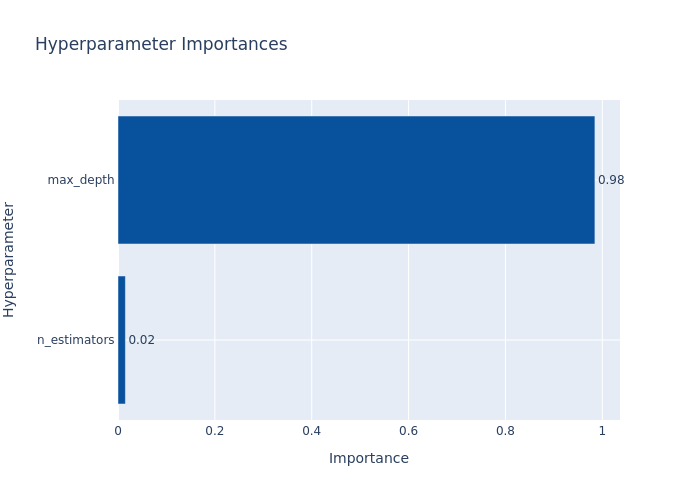

In [14]:
f = optuna.visualization.plot_param_importances(study_tpe)
Image(f.to_image(format="png", engine='kaleido'))

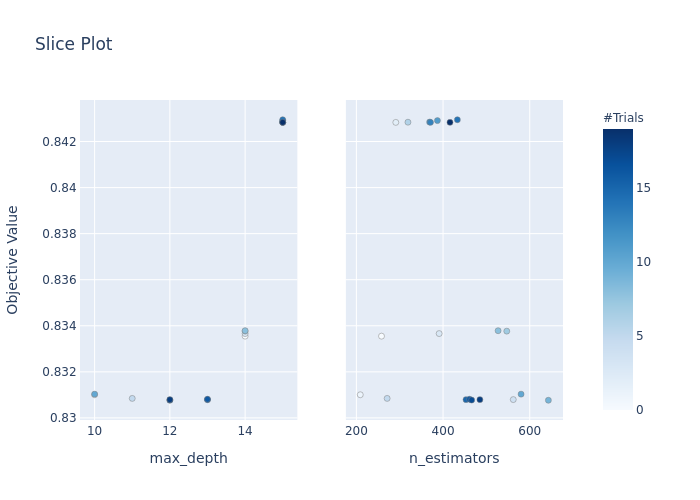

In [15]:
f = optuna.visualization.plot_slice(study_tpe,params=['max_depth', 'n_estimators'])
Image(f.to_image(format="png", engine='kaleido'))

Let's look at how the optimisation within the study progressed with the history plot for the study

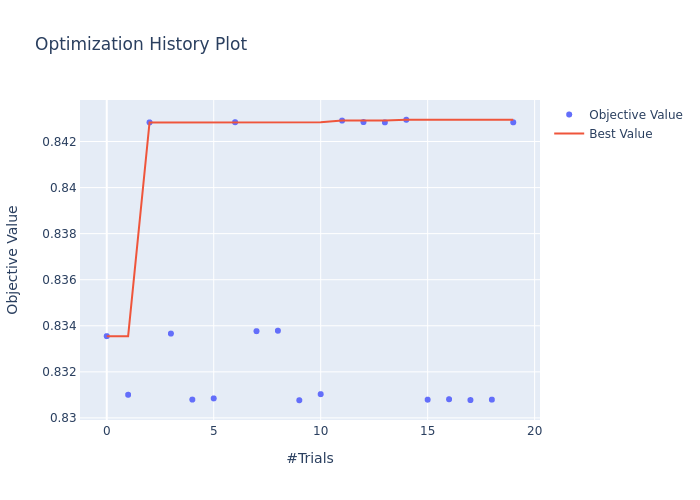

In [16]:
f = optuna.visualization.plot_optimization_history(study_tpe)
Image(f.to_image(format="png", engine='kaleido'))

The following is a parallel coordinate plot to understand the relationships between the parameters.

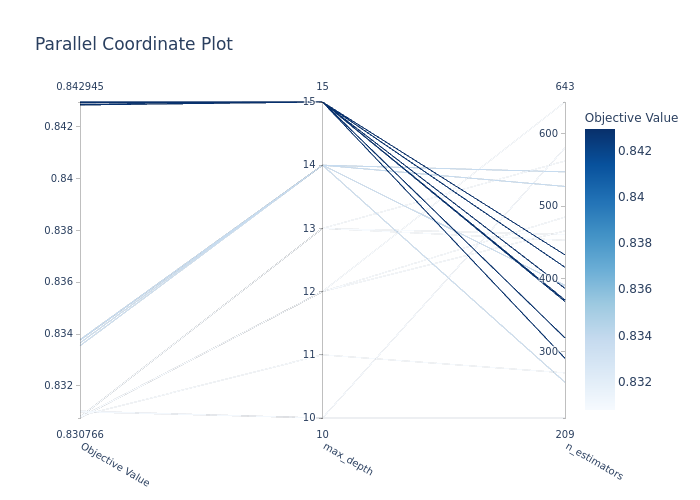

In [17]:
f = optuna.visualization.plot_parallel_coordinate(study_tpe, params=['max_depth', 'n_estimators'])
Image(f.to_image(format="png", engine='kaleido'))

## Conluding Remarks

This notebook shows how RAPIDS and Optuna can be used along with dask to run multi-GPU HPO jobs, and can be used as a starting point for anyone wanting to get started with the framework. It also provides some visualization tools to interpret the results.